In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import time
import math

pd.set_option("display.precision", 20)

In [33]:
def read_clean_csv(file, double_headed = True, x='tempC', y='fracDensity'):
    '''
    Reads and cleans a csv imported from WebPlotDigitilizer

    file: csv file imported from WebPlotDigitilizer.
    double_headed: weather the csv has more two headers (e.g. 2Kmin and [x,y])
    x: name of the columns that represents the x axis
    y: name of the columns that represents the y axis
    '''
    if double_headed:
        df = pd.read_csv(file, header=[0,1])
        new_cols = [list(tup) for tup in df.columns.values]
        for i in range(len(df.columns.values)):
            if i % 2 != 0:
                new_cols[i][0] = new_cols[i-1][0]
                new_cols[i][1] = y
            else:
                new_cols[i][1] = x
        columns = [tuple(lis) for lis in new_cols]
        df.columns = columns
        df.columns = ['_'.join(col) for col in df.columns.values]
    else:
        df = pd.read_csv(file,header=None)
        df.columns = [x,y]
    return df
    

In [34]:
def model_gomez(df, beta, Ea, A, n, G, R = 8.31446262, beta_SI = False):
    '''
    Uses the data to predict the densification in acordance to the Gomez-Hotza model
    
    df: clean data from WebPlotDigitizer
    beta: heating rate of the process. Either in °C(K)/min or °C(K)/s
    Ea: material's activation energy
    A: Gomez-Hotza coefficient
    n: mass transport coefficiente, varies from 0.0 to 1.0
    G: mean particle size
    R: molar gas constant
    beta_SI: weather the beta value is expressed in °C(K)/s or not
    '''
    #df = df1.copy
    if not beta_SI:
        beta_sec = beta/60
    else:
        beta_sec = beta
    df['tempK'] = df['tempC'] + 273.15
    df['theta'] = 1 - df['fracDensity']
    df['ln_theta_theta0'] = np.log(df['theta']/df['theta'][0])
    df['t'] = (df['tempK'] - df['tempK'][0])/beta_sec
    df['tn'] = df['t'] ** n
    df['Tminus1'] = 1/df['tempK']
    df['exp_ERT'] = np.exp(-((Ea)/(R *df['tempK'])))
    df['tnj_tnj1'] = np.zeros(len(df['tn']))
    for i in range(len(df['tn'])-1):
        df['tnj_tnj1'][i] =  (df['tn'][i+1] - df['tn'][i])
    df['pred'] = (A/G) * (df['Tminus1'] * df['tnj_tnj1'] * df['exp_ERT'])
    df['abs_error'] = np.abs(df['pred'] - df['ln_theta_theta0'])
    df['squared_error'] = np.square(df['pred'] - df['ln_theta_theta0'])
    return df

In [35]:
def mae(df, column):
    '''
    Computes the mean absolute error of a column in a DataFrame
    
    df: DataFrame
    column: string representig the name of the column in whiche the absolute error is expressed
    '''
    mean_abs_error = np.mean((df[column]))
    return mean_abs_error

In [36]:
def mse(df, column):
    '''
    Computes the mean squared error of a column in a DataFrame
    
    df: DataFrame
    column: string representig the name of the column in whiche the squared error is expressed
    '''
    mean_squared_error = np.mean((df[column]))
    return mean_squared_error

In [37]:
def model_validation(df, A_values, Ea_values, n_values, beta, G, metric = 'mse',R = 8.31446262, beta_SI = False, print_iteration = False ):
    '''
    Evaluates the parameters A, Ea and n of the Gomez-Hotza model based-off a Grid Search of parameters
    
    df: DataFrame
    A_values: list of values of A to be tested
    Ea_values: list of values of Ea to be tested
    n_values: list of values of n to be tested
    beta: heating rate of the process. Either in °C(K)/min or °C(K)/s
    G: mean particle size
    metric: either 'mse' (mean squared error) or 'mae'(mean absolute error), it refers to the error parameter used
    R: molar gas constant
    beta_SI: weather the beta value is expressed in °C(K)/s or not
    print_iteration: when True the program prints the chosen error for each iteration
    '''
    st = time.time()
    best_error = float('inf')
    list_of_dict = []
    best_params ={}
    for A in A_values:
        for Ea in Ea_values:
            for n in n_values:
                data = model_gomez(df, beta, Ea, A, n, G)
                if metric == 'mse':
                    error = mse(data, 'squared_error')
                    list_of_dict.append({'A':A, 'Ea': Ea, 'n':n,'MSE':error})
                    if print_iteration:
                        print(f'MSE para [{A},{Ea}, {n}] = {error}')
                    if error < best_error:
                        best_error = error
                        best_params = {'A':A, 'Ea': Ea, 'n':n}
                else:
                    error = mae(data, 'abs_error')
                    list_of_dict.append({'A':A, 'Ea': Ea, 'n':n,'MAE':error})
                    if print_iteration:
                        print(f'MSE para [{A},{Ea}, {n}] = {error}')
                    if error < best_error:
                        best_error = error
                        best_params = {'A':A, 'Ea': Ea, 'n':n}
    print(f'Best {metric}     :{best_error}')
    print(f'Best params  :{best_params}')
    end = time.time() - st
    print(f'Run time: {end}s')
    return list_of_dict

In [38]:
def predict_gomez(T0, Tf, nos, material_name, graph_time = True):
    temperatures = np.linspace(T0, Tf, nos)
    beta = float(input('Set the heating rate in K/s: \n'))
    time = [(T-temperatures[0])/beta for T in temperatures]
    material = materials[materials['material'] == material_name]
    A = float(material['A'].iloc[0])
    Ea = float(material['Ea'].iloc[0])
    n = float(material['n'].iloc[0])
    G = float(input('Set the particle mean size in meters (Use eX when needed): \n'))
    R = 8.31446262
    tn = [t ** n for t in time]
    tn_tj = np.zeros(len(tn))
    for i in range(len(tn)-1):
        tn_tj[i] = tn[i+1] - tn[i]
    preds = (A/G) * tn_tj * 1/temperatures * np.exp(-(Ea/R * temperatures))
    return preds

    


In [39]:
zirconia = {'material':['zirconia'], 'formula': ['Al2O3'], 'A':[100], 'Ea':[611111.11], 'n':[0.2]}
materials = pd.DataFrame.from_dict(zirconia)
materials

,material,formula,A,Ea,n
0,zirconia,Al2O3,100,611111.10999999998603016138,0.2000000000000000111


In [40]:
teste = predict_gomez(500, 1300, 20, 'zirconia')

Len tn_tj: 20
Len temperatures: 20


In [41]:
mazaheri = read_clean_csv("C:/Users/gupau/Documents/UFSC - PC/Semestre 23.2/TCC/Mazaheri/mazaheri.csv")
display(mazaheri.head())

,2Kmin_tempC,2Kmin_fracDensity,5Kmin_tempC,5Kmin_fracDensity,20Kmin_tempC,20Kmin_fracDensity
0,1064.38642872879495371308,0.45614349129895948032,1069.15950649922888260335,0.45307199729241387498,1090.29742233972228859784,0.45487328990288561359
1,1068.47763824630965245888,0.45820521970047667359,1073.25071601674380872282,0.45410681747987191592,1094.38863185723721471732,0.45705237924315228470
2,1072.56884776382457857835,0.46012024692855690855,1077.34192553425873484230,0.45396802827983367967,1098.47984137475191346311,0.45806763927415228288
3,1076.66005728133950469783,0.46174187180976311584,1081.43313505177343358810,0.45485614729385481780,1102.57105089226706695626,0.46017826806681511043
4,1080.75126679885443081730,0.46351019786440611492,1085.52434456928835970757,0.45608656904589550685,1106.66226040978199307574,0.46184879333916689648


In [42]:
mazaheri_2K = pd.DataFrame(mazaheri[mazaheri.columns.values[0:2]])
mazaheri_5K = pd.DataFrame(mazaheri[mazaheri.columns.values[2:4]])
mazaheri_20K = pd.DataFrame(mazaheri[mazaheri.columns.values[4:]])

In [43]:
mazaheri_2K.columns = [col[6:] for col in mazaheri_2K.columns.values]
mazaheri_5K.columns = [col[6:] for col in mazaheri_5K.columns.values]
mazaheri_20K.columns = [col[7:] for col in mazaheri_20K.columns.values]

In [44]:
validation2K = pd.DataFrame(model_validation(mazaheri_2K, np.linspace(100, 50, 10), np.linspace(500000,700000,10), [0.2, 0.3, 0.4, 0.5], beta=2, G=7.5e-8))

Best mse     :0.8095455915530891
Best params  :{'A': 100.0, 'Ea': 611111.1111111111, 'n': 0.2}
Run time: 11.455301284790039s


In [45]:
validation5K = pd.DataFrame(model_validation(mazaheri_5K, np.linspace(100, 50, 10), np.linspace(500000,700000,10), [0.2, 0.3, 0.4, 0.5], beta=5, G=7.5e-8))

Best mse     :0.2961804701089709
Best params  :{'A': 100.0, 'Ea': 611111.1111111111, 'n': 0.2}
Run time: 11.173684120178223s


In [46]:
validation20K = pd.DataFrame(model_validation(mazaheri_20K, np.linspace(100, 50, 10), np.linspace(500000,700000,10), [0.2, 0.3, 0.4, 0.5], beta=20, G=7.5e-8))

Best mse     :0.09115164838971618
Best params  :{'A': 100.0, 'Ea': 611111.1111111111, 'n': 0.2}
Run time: 11.049567461013794s


c:\Users\gupau\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


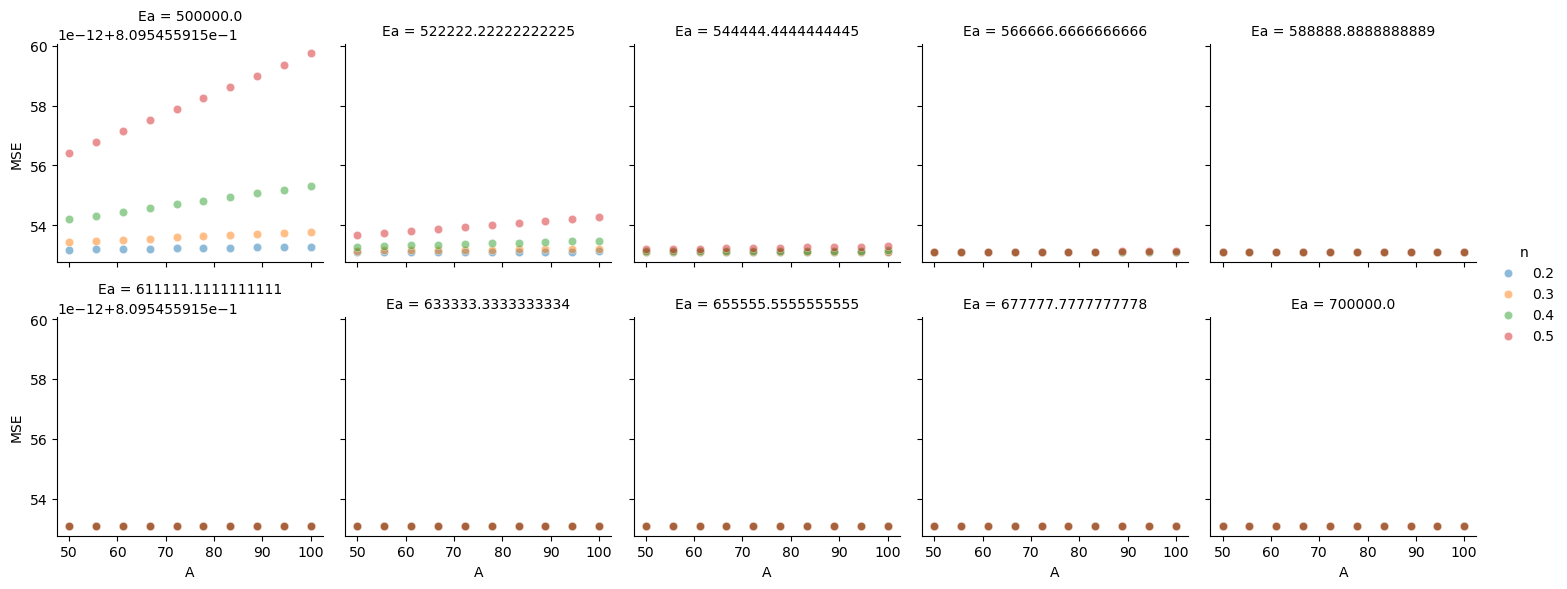

In [47]:
g = sns.FacetGrid(validation2K, col='Ea', hue='n', col_wrap=5)
g.map(sns.scatterplot, 'A', 'MSE', alpha=0.5)
g.add_legend()
#plt.yscale('log')

c:\Users\gupau\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


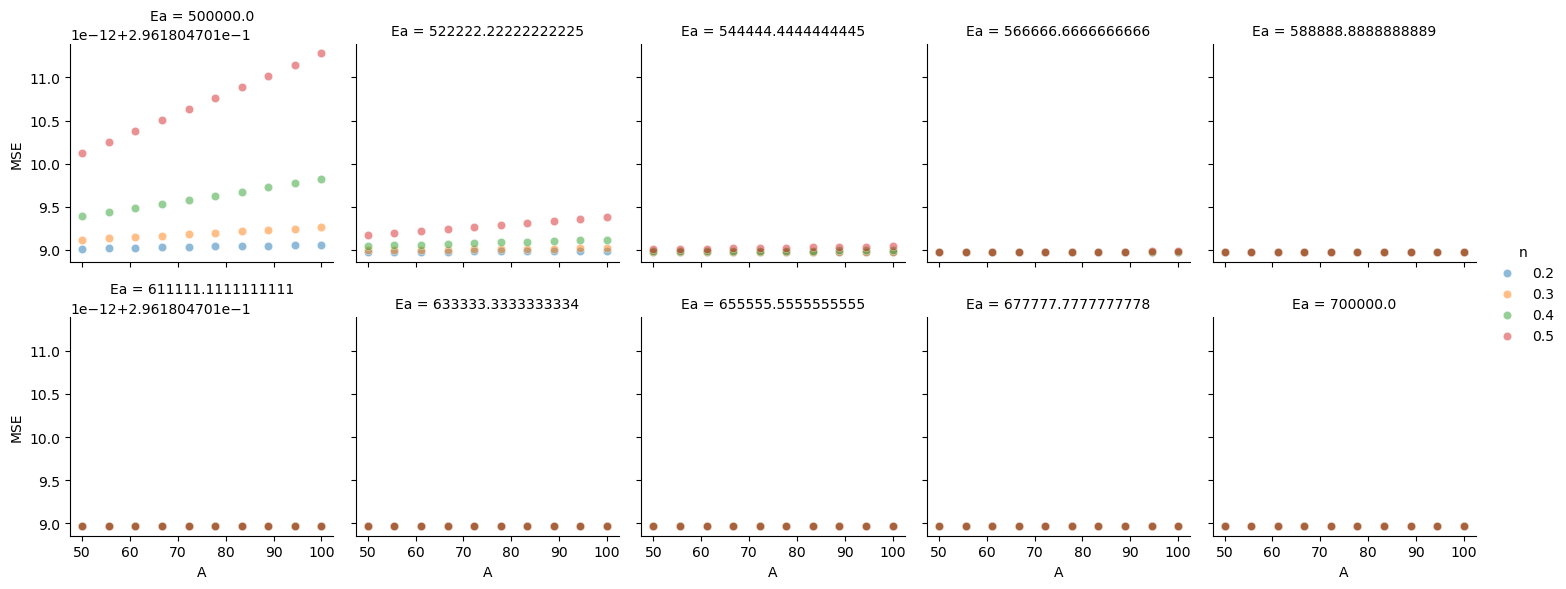

In [48]:
g = sns.FacetGrid(validation5K, col='Ea', hue='n', col_wrap=5)
g.map(sns.scatterplot, 'A', 'MSE', alpha=0.5)
g.add_legend()
#plt.yscale('log')

c:\Users\gupau\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


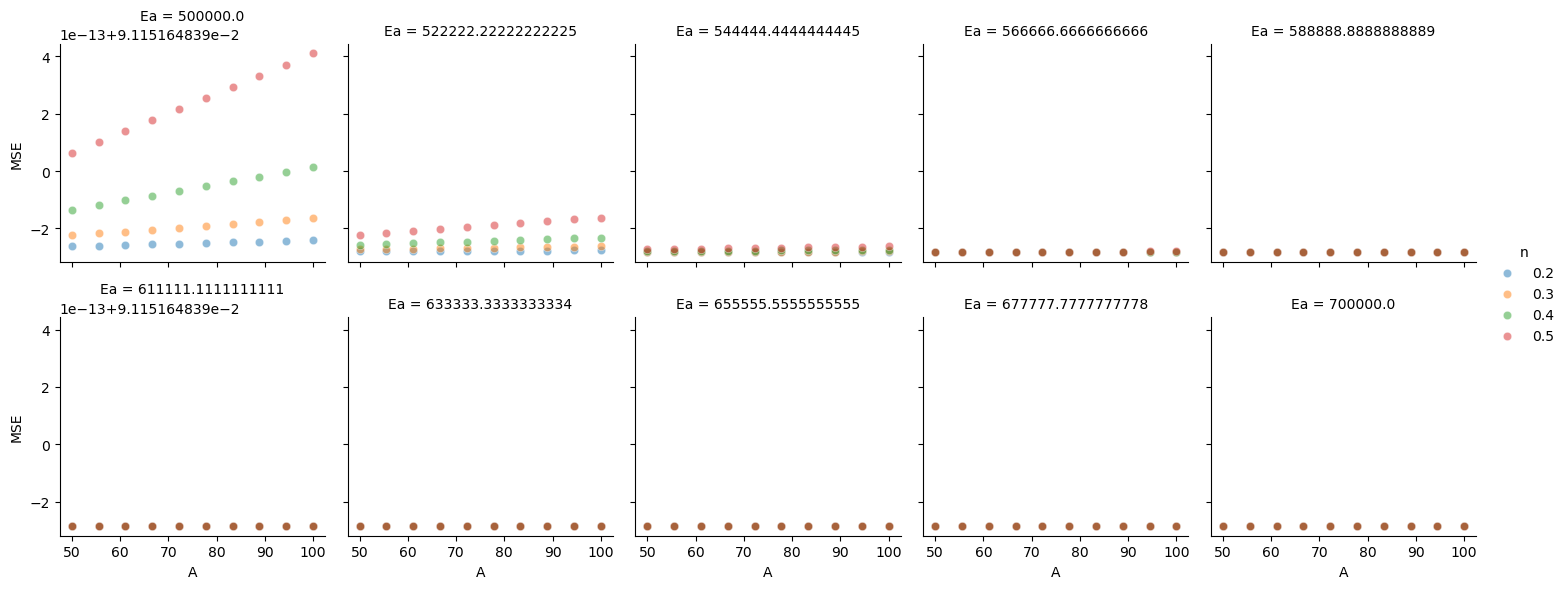

In [49]:
g = sns.FacetGrid(validation20K, col='Ea', hue='n', col_wrap=5)
g.map(sns.scatterplot, 'A', 'MSE',alpha=0.5)
g.add_legend()
#pt.yscale('log')

In [50]:
plot_mazaheri_2K = model_gomez(mazaheri_2K, beta=2, Ea=611111.11, A=100, n=0.2, G = 7.5e-8)
plot_mazaheri_2K.head()

,tempC,fracDensity,tempK,theta,ln_theta_theta0,t,tn,Tminus1,exp_ERT,tnj_tnj1,pred,abs_error,squared_error
0,1064.38642872879495371308,0.45614349129895948032,1337.53642872879481728887,0.54385650870104051968,0.00000000000000000000,0.00000000000000000000,0.00000000000000000000,0.00074764318826845550,1.36402252818188204694e-24,2.61694499951418624306,0.00000000000000000356,0.00000000000000000356,1.26618892788582844187e-35
1,1068.47763824630965245888,0.45820521970047667359,1341.62763824630974340835,0.54179478029952332641,-0.00379814568624593481,122.73628552544778358424,2.61694499951418624306,0.00074536329715682982,1.61286089144453490091e-24,0.38913541654547589843,0.00000000000000000062,0.00379814568624593524,1.44259106539486064069e-05
2,1072.56884776382457857835,0.46012024692855690855,1345.71884776382466952782,0.53987975307144309145,-0.00733900602793649721,245.47257105089556716848,3.00608041605966214149,0.00074309726854290240,1.90515265764677294152e-24,0.25392893710727459933,0.00000000000000000048,0.00733900602793649808,5.38610094780882545876e-05
3,1076.66005728133950469783,0.46174187180976311584,1349.81005728133959564730,0.53825812819023688416,-0.01034720401868534541,368.20885657634335075272,3.26000935316693674082,0.00074084497637697704,2.24814425902300864586e-24,0.19307027574959967353,0.00000000000000000043,0.01034720401868534541,1.07064631004298159867e-04
4,1080.75126679885443081730,0.46351019786440611492,1353.90126679885452176677,0.53648980213559394059,-0.01363788753703220474,490.94514210179113433696,3.45307962891653641435,0.00073860629613294200,2.65023307906710495055e-24,0.15759700932577436205,0.00000000000000000041,0.01363788753703220474,1.85991976472738322276e-04


<Axes: xlabel='tempK', ylabel='ln_theta_theta0'>

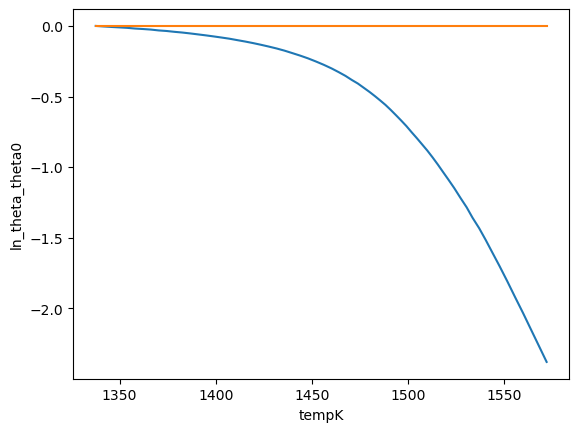

In [51]:
sns.lineplot(data=plot_mazaheri_2K, x='tempK', y='ln_theta_theta0')
sns.lineplot(data=plot_mazaheri_2K, x='tempK', y='pred')

sns.lineplot(data=)